## 전체 공통 함수

### 1. 데이터 보간 함수

- 데이터의 시간 간격을 0.5초의 등간격으로 맞추고 그에 따른 좌표 값을 보간함
- 가장 많이 사용되는 3차 스플라인 보간 적용

In [1]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# 데이터 보간 - 위도, 고도, 경도 값을 0.5초 시간 간격으로 보간
def spline_interpolation(x, y):
    # x: 보간할 데이터의 x 값 (시간)
    # y: 보간할 데이터의 y 값 (위도, 고도, 경도)

    # 3차 스플라인 보간 함수 생성
    f = interp1d(x, y, kind='cubic')

    # 시간 범위 설정
    start_time = min(x)
    end_time = max(x)

    # 0.5초 간격의 시간 배열을 생성
    new_x = np.arange(start_time, end_time, 0.5)

    # 위도, 경도, 고도 보간
    new_y = f(new_x)

    return new_x, new_y

### 2. 시퀀스 나누는 함수

- 학습을 위해 데이터를 시퀀스 형태로 나눔
- look back과 forward에 따라 학습에 사용될 x값의 구간과 y값을 반환함
- 초기 look back은 10, forward는 0이다.

In [2]:
# 시퀀스 생성 함수
# look back : 10 (5초간의 위도, 고도, 경도 데이터를 x값으로 사용)
# forward : 0 (0.5초 뒤의 위도, 고도, 경도 데이터를 y값으로 사용)
def create_sequences(df, look_back=10, forward=0):
    xs = []
    ys = []
    for i in range(len(df) - look_back - forward):
        x = df.iloc[i:(i+look_back)].values
        y = df.iloc[i+look_back+forward].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

### 3. 시간 소수점 절사 함수

- 불필요한 시간 소수점 제거

In [3]:
import math

# 시간 소수점 절사 함수
def truncation(df):
    new_time = []

    for a in df['time']:
      new_time.append(math.floor(a * 10) / 10)

    df['time'] = new_time

    return df

### 4. 스케일링 함수

- MinMaxScaling 적용 함수


In [4]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaling 적용 함수
def min_max_scaling(df):

    # time 삭제 df 생성
    mid_df=df.drop(columns='time')

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(mid_df)

    min_max_data = min_max_scaler.transform(mid_df)

    new_data = pd.DataFrame(min_max_data)

    # time 추가
    new_data.insert(0, 'time', df['time'])

    # 나머지 열의 이름 가져오기
    column_names = mid_df.columns.tolist()

    column_names.insert(0, 'time')

    print(column_names)

    # 새로운 데이터프레임에 열 이름 설정
    new_data.columns = column_names

    return min_max_scaler, new_data

### 5. train/validation/test 분리 함수

- Train, Validation, Test 데이터셋을 분리하는 함수이다.
- 각각의 비율은 6:2:2 이다.

In [5]:
# train/validation/test 분리 함수 (시계열 데이터용, 6:2:2 비율)
def split_train_val_test(df):
    n = len(df)

    # 데이터셋 크기 계산
    train_end = int(0.6 * n)
    val_end = int(0.8 * n)  # 0.6 + 0.2

    # 순차적으로 데이터 분할
    train_data = df[:train_end]     # 처음 60%는 train 데이터
    val_data = df[train_end:val_end] # 그 다음 20%는 validation 데이터
    test_data = df[val_end:]        # 마지막 20%는 test 데이터

    # 데이터 크기 출력 (원한다면)
    # print("Train set:", train_data.shape)
    # print("Validation set:", val_data.shape)
    # print("Test set:", test_data.shape)

    return train_data, val_data, test_data

### 6. 경로 시각화 함수

- 실제 경로와 예측 경로를 각각 그래프로 생성

In [6]:
import matplotlib.pyplot as plt

# 경로 시각화 함수
def prediction_visualization(y_test, y_pred):
    # 시각화를 위해 위도, 경도, 고도 분리
    y_test_lat = y_test[:, 0]
    y_test_lon = y_test[:, 1]
    y_test_alt = y_test[:, 2]

    y_pred_lat = y_pred[:, 0]
    y_pred_lon = y_pred[:, 1]
    y_pred_alt = y_pred[:, 2]

    # 3D 그래프 생성
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 실제 값 플롯
    ax.scatter(y_test_lat, y_test_lon, y_test_alt, c='b', marker='o', label='Actual')

    # 예측 값 플롯
    ax.scatter(y_pred_lat, y_pred_lon, y_pred_alt, c='r', marker='^', label='Predicted')

    # 그래프 제목 및 축 레이블 설정
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 범례
    ax.legend()

    # 그래프를 화면에 출력
    plt.show()

### 성능 테스트 함수

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluation(y_test, y_pred):

    # MSE (Mean Squared Error) 계산
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # MAE (Mean Absolute Error) 계산
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error: {mae}")

    # 예측 결과와 실제 값을 비교하는 샘플 출력
    for i in range(5):  # 예시로 첫 5개만 출력
        print(f"Actual: {y_test[i]}, Predicted: {y_pred[i]}")

## 전처리

### 1. 데이터셋 가져오기

In [8]:
import pandas as pd

# 데이터셋 가져오기 (필요시 저장 경로 수정)
raw = pd.read_csv("OnboardGPS.csv")

### 2. 데이터셋 전처리

- 데이터셋 보간
- 소수점 절사
- MinMaxScaling 적용


In [9]:
df = raw[['Timpstemp', ' lat', ' lon', ' alt']]

new_x, lat = spline_interpolation(df['Timpstemp'] / 1e6 , df[' lat'])
new_x, lon = spline_interpolation(df['Timpstemp'] / 1e6 , df[' lon'])
new_x, alt = spline_interpolation(df['Timpstemp'] / 1e6 , df[' alt'])

df = pd.DataFrame({"time":new_x, "lat":lat, "lon":lon, "alt":alt})

df = truncation(df)
scaler, df = min_max_scaling(df)

['time', 'lat', 'lon', 'alt']


## 모델 선언

### 1. 모델 클래스 선언
- GRU를 사용한 모델 클래스 선언
- 구조 : GRU + Fully Connected Layer

In [10]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 하이퍼파라미터와 모델 정의
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_units, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_units, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력만 사용
        return out

In [11]:
# 모델 학습 함수
def train_model(model, criterion, optimizer, loader, device, history):
    model.train()
    total_loss = 0
    for batch_x, batch_y in loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)

    # history가 주어지면 학습 손실 기록
    if history is not None:
        history['train_loss'].append(avg_loss)

    return avg_loss

In [12]:
# 검증 및 테스트 함수
def evaluate_model(model, criterion, loader, device, history):
    model.eval()
    total_loss = 0
    true_values = []
    predictions = []

    start_time = time.time()  # 예측 시작 시간 기록

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            total_loss += loss.item()
            true_values.append(batch_y.cpu().numpy())
            predictions.append(output.cpu().numpy())

    end_time = time.time()  # 예측 종료 시간 기록
    total_inference_time = end_time - start_time

    # print(f"Total Inference Time: {total_inference_time:.2f} seconds")

    avg_loss = total_loss / len(loader)

    # history가 주어지면 검증 손실 기록
    if history is not None:
        history['val_loss'].append(avg_loss)

    return avg_loss, true_values, predictions

In [13]:
# 데이터 로더 생성 함수
def prepare_dataloader(df, batch_size, look_back=10, forward=0):

  # train, validation, test 분리
  train_data, val_data, test_data = split_train_val_test(df)

  # 각 데이터셋에서 시퀀스 생성
  X_train, y_train = create_sequences(train_data[['lat', 'lon', 'alt']], look_back, forward)
  X_val, y_val = create_sequences(val_data[['lat', 'lon', 'alt']], look_back, forward)
  X_test, y_test = create_sequences(test_data[['lat', 'lon', 'alt']], look_back, forward)

  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_val = torch.tensor(X_val, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.float32)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  train_dataset = TensorDataset(X_train, y_train)
  validation_dataset = TensorDataset(X_val, y_val)
  test_dataset = TensorDataset(X_test, y_test)

  # 데이터 로더 생성
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

### 2. 하이퍼파라미터 불러오기

In [14]:
import json

# 1. 저장된 하이퍼파라미터 불러오기
with open("best_hyperparameters_gru.json", "r") as f:
    best_params = json.load(f)

print("Loaded best hyperparameters:", best_params)

Loaded best hyperparameters: {'n_layers': 1, 'n_units_l0': 117, 'learning_rate': 0.0024064401794910207, 'batch_size': 26}


## 학습

1. 시퀀스 생성
2. Train, Validation, Test 분리
3. DataLoader에 load

### 1. 최적의 파라미터로 모델 학습

In [15]:
# 최적의 모델 학습
# best_params = study.best_params

train_loader, val_loader, test_loader = prepare_dataloader(df, best_params['batch_size'])

best_model = GRUModel(input_size=3, hidden_units=best_params['n_units_l0'], output_size=3, num_layers=best_params['n_layers'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = torch.nn.MSELoss()

/home/202004182/anaconda3/envs/env0/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538459595/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [16]:
import time
import torch

best_model.train()
total_train_time = 0  # 총 학습 시간 기록 변수
history = {'train_loss': [], 'val_loss': []}

num_epochs = 300
for epoch in range(num_epochs):  # 최종 모델 학습
    best_model.train()
    train_loss = 0.0
    epoch_start_time = time.time()  # 에포크 시작 시간 기록
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        output = best_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # history가 주어지면 학습 손실 기록
    history['train_loss'].append(train_loss / len(train_loader))

    epoch_end_time = time.time()  # 에포크 종료 시간 기록
    epoch_duration = epoch_end_time - epoch_start_time  # 한 에포크의 학습 시간
    total_train_time += epoch_duration  # 총 학습 시간에 추가

    # Validation set에서 성능 측정
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
            batch_y = batch_y.to(device)
            output = best_model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()


    # history가 주어지면 학습 손실 기록
    history['val_loss'].append(val_loss / len(val_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 모델 저장
    if (epoch + 1) % 50 == 0:
      model_save_path = f"./output_model/best_model_epoch_{epoch+1}.pth"
      torch.save({
        'model_state_dict': best_model.state_dict(),
        'train_losses': history['train_loss'],
        'val_losses': history['val_loss']
      }, model_save_path)
      print(f"Model saved: {model_save_path}")

    print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_duration:.2f} seconds.")

print(f"Total training time: {total_train_time:.2f} seconds.")



Epoch [1/300], Train Loss: 2.2244, Val Loss: 0.0193
Epoch 1/300 completed in 1.17 seconds.


Epoch [2/300], Train Loss: 0.0352, Val Loss: 0.0042
Epoch 2/300 completed in 1.01 seconds.


Epoch [3/300], Train Loss: 0.0125, Val Loss: 0.0034
Epoch 3/300 completed in 1.10 seconds.


Epoch [4/300], Train Loss: 0.0113, Val Loss: 0.0037
Epoch 4/300 completed in 0.92 seconds.


Epoch [5/300], Train Loss: 0.0097, Val Loss: 0.0042
Epoch 5/300 completed in 0.91 seconds.


Epoch [6/300], Train Loss: 0.0082, Val Loss: 0.0021
Epoch 6/300 completed in 0.94 seconds.


Epoch [7/300], Train Loss: 0.0075, Val Loss: 0.0020
Epoch 7/300 completed in 0.92 seconds.


Epoch [8/300], Train Loss: 0.0063, Val Loss: 0.0026
Epoch 8/300 completed in 0.93 seconds.


Epoch [9/300], Train Loss: 0.0066, Val Loss: 0.0017
Epoch 9/300 completed in 0.90 seconds.


Epoch [10/300], Train Loss: 0.0058, Val Loss: 0.0016
Epoch 10/300 completed in 0.87 seconds.


Epoch [11/300], Train Loss: 0.0063, Val Loss: 0.0018
Epoch 11/300 completed in 1.13 seconds.


Epoch [12/300], Train Loss: 0.0052, Val Loss: 0.0015
Epoch 12/300 completed in 0.93 seconds.


Epoch [13/300], Train Loss: 0.0047, Val Loss: 0.0017
Epoch 13/300 completed in 0.92 seconds.


Epoch [14/300], Train Loss: 0.0043, Val Loss: 0.0013
Epoch 14/300 completed in 1.04 seconds.


Epoch [15/300], Train Loss: 0.0041, Val Loss: 0.0011
Epoch 15/300 completed in 0.93 seconds.


Epoch [16/300], Train Loss: 0.0042, Val Loss: 0.0016
Epoch 16/300 completed in 0.89 seconds.


Epoch [17/300], Train Loss: 0.0049, Val Loss: 0.0025
Epoch 17/300 completed in 0.88 seconds.


Epoch [18/300], Train Loss: 0.0045, Val Loss: 0.0029
Epoch 18/300 completed in 0.92 seconds.


Epoch [19/300], Train Loss: 0.0034, Val Loss: 0.0011
Epoch 19/300 completed in 0.91 seconds.


Epoch [20/300], Train Loss: 0.0068, Val Loss: 0.0018
Epoch 20/300 completed in 0.90 seconds.


Epoch [21/300], Train Loss: 0.0042, Val Loss: 0.0012
Epoch 21/300 completed in 0.86 seconds.


Epoch [22/300], Train Loss: 0.0041, Val Loss: 0.0031
Epoch 22/300 completed in 0.93 seconds.


Epoch [23/300], Train Loss: 0.0045, Val Loss: 0.0014
Epoch 23/300 completed in 1.00 seconds.


Epoch [24/300], Train Loss: 0.0031, Val Loss: 0.0013
Epoch 24/300 completed in 0.84 seconds.


Epoch [25/300], Train Loss: 0.0048, Val Loss: 0.0016
Epoch 25/300 completed in 0.98 seconds.


Epoch [26/300], Train Loss: 0.0038, Val Loss: 0.0009
Epoch 26/300 completed in 0.84 seconds.


Epoch [27/300], Train Loss: 0.0034, Val Loss: 0.0027
Epoch 27/300 completed in 0.95 seconds.


Epoch [28/300], Train Loss: 0.0050, Val Loss: 0.0012
Epoch 28/300 completed in 1.05 seconds.


Epoch [29/300], Train Loss: 0.0038, Val Loss: 0.0009
Epoch 29/300 completed in 0.83 seconds.


Epoch [30/300], Train Loss: 0.0034, Val Loss: 0.0019
Epoch 30/300 completed in 0.90 seconds.


Epoch [31/300], Train Loss: 0.0038, Val Loss: 0.0013
Epoch 31/300 completed in 0.87 seconds.


Epoch [32/300], Train Loss: 0.0032, Val Loss: 0.0011
Epoch 32/300 completed in 0.84 seconds.


Epoch [33/300], Train Loss: 0.0035, Val Loss: 0.0020
Epoch 33/300 completed in 1.02 seconds.


Epoch [34/300], Train Loss: 0.0039, Val Loss: 0.0012
Epoch 34/300 completed in 0.86 seconds.


Epoch [35/300], Train Loss: 0.0046, Val Loss: 0.0010
Epoch 35/300 completed in 0.90 seconds.


Epoch [36/300], Train Loss: 0.0038, Val Loss: 0.0015
Epoch 36/300 completed in 1.03 seconds.


Epoch [37/300], Train Loss: 0.0034, Val Loss: 0.0015
Epoch 37/300 completed in 0.90 seconds.


Epoch [38/300], Train Loss: 0.0039, Val Loss: 0.0009
Epoch 38/300 completed in 1.05 seconds.


Epoch [39/300], Train Loss: 0.0025, Val Loss: 0.0008
Epoch 39/300 completed in 0.92 seconds.


Epoch [40/300], Train Loss: 0.0027, Val Loss: 0.0018
Epoch 40/300 completed in 1.07 seconds.


Epoch [41/300], Train Loss: 0.0034, Val Loss: 0.0008
Epoch 41/300 completed in 0.88 seconds.


Epoch [42/300], Train Loss: 0.0027, Val Loss: 0.0008
Epoch 42/300 completed in 1.10 seconds.


Epoch [43/300], Train Loss: 0.0032, Val Loss: 0.0013
Epoch 43/300 completed in 1.13 seconds.


Epoch [44/300], Train Loss: 0.0063, Val Loss: 0.0015
Epoch 44/300 completed in 0.99 seconds.


Epoch [45/300], Train Loss: 0.0025, Val Loss: 0.0007
Epoch 45/300 completed in 0.95 seconds.


Epoch [46/300], Train Loss: 0.0029, Val Loss: 0.0014
Epoch 46/300 completed in 0.89 seconds.


Epoch [47/300], Train Loss: 0.0027, Val Loss: 0.0008
Epoch 47/300 completed in 1.14 seconds.


Epoch [48/300], Train Loss: 0.0029, Val Loss: 0.0008
Epoch 48/300 completed in 0.93 seconds.


Epoch [49/300], Train Loss: 0.0033, Val Loss: 0.0009
Epoch 49/300 completed in 0.88 seconds.


Epoch [50/300], Train Loss: 0.0028, Val Loss: 0.0010
Model saved: ./output_model/best_model_epoch_50.pth
Epoch 50/300 completed in 0.94 seconds.


Epoch [51/300], Train Loss: 0.0029, Val Loss: 0.0008
Epoch 51/300 completed in 1.04 seconds.


Epoch [52/300], Train Loss: 0.0037, Val Loss: 0.0010
Epoch 52/300 completed in 1.01 seconds.


Epoch [53/300], Train Loss: 0.0025, Val Loss: 0.0008
Epoch 53/300 completed in 1.12 seconds.


Epoch [54/300], Train Loss: 0.0028, Val Loss: 0.0008
Epoch 54/300 completed in 0.91 seconds.


Epoch [55/300], Train Loss: 0.0026, Val Loss: 0.0012
Epoch 55/300 completed in 1.09 seconds.


Epoch [56/300], Train Loss: 0.0031, Val Loss: 0.0009
Epoch 56/300 completed in 1.07 seconds.


Epoch [57/300], Train Loss: 0.0036, Val Loss: 0.0021
Epoch 57/300 completed in 1.13 seconds.


Epoch [58/300], Train Loss: 0.0028, Val Loss: 0.0011
Epoch 58/300 completed in 1.10 seconds.


Epoch [59/300], Train Loss: 0.0026, Val Loss: 0.0008
Epoch 59/300 completed in 0.88 seconds.


Epoch [60/300], Train Loss: 0.0030, Val Loss: 0.0015
Epoch 60/300 completed in 1.03 seconds.


Epoch [61/300], Train Loss: 0.0029, Val Loss: 0.0008
Epoch 61/300 completed in 0.98 seconds.


Epoch [62/300], Train Loss: 0.0024, Val Loss: 0.0009
Epoch 62/300 completed in 1.09 seconds.


Epoch [63/300], Train Loss: 0.0028, Val Loss: 0.0008
Epoch 63/300 completed in 1.23 seconds.


Epoch [64/300], Train Loss: 0.0026, Val Loss: 0.0015
Epoch 64/300 completed in 0.95 seconds.


Epoch [65/300], Train Loss: 0.0026, Val Loss: 0.0014
Epoch 65/300 completed in 1.12 seconds.


Epoch [66/300], Train Loss: 0.0028, Val Loss: 0.0016
Epoch 66/300 completed in 0.91 seconds.


Epoch [67/300], Train Loss: 0.0039, Val Loss: 0.0012
Epoch 67/300 completed in 1.01 seconds.


Epoch [68/300], Train Loss: 0.0035, Val Loss: 0.0010
Epoch 68/300 completed in 0.89 seconds.


Epoch [69/300], Train Loss: 0.0026, Val Loss: 0.0014
Epoch 69/300 completed in 0.89 seconds.


Epoch [70/300], Train Loss: 0.0023, Val Loss: 0.0007
Epoch 70/300 completed in 1.02 seconds.


Epoch [71/300], Train Loss: 0.0024, Val Loss: 0.0013
Epoch 71/300 completed in 0.94 seconds.


Epoch [72/300], Train Loss: 0.0025, Val Loss: 0.0007
Epoch 72/300 completed in 0.90 seconds.


Epoch [73/300], Train Loss: 0.0024, Val Loss: 0.0013
Epoch 73/300 completed in 0.99 seconds.


Epoch [74/300], Train Loss: 0.0053, Val Loss: 0.0010
Epoch 74/300 completed in 1.13 seconds.


Epoch [75/300], Train Loss: 0.0028, Val Loss: 0.0007
Epoch 75/300 completed in 1.18 seconds.


Epoch [76/300], Train Loss: 0.0023, Val Loss: 0.0015
Epoch 76/300 completed in 1.13 seconds.


Epoch [77/300], Train Loss: 0.0031, Val Loss: 0.0021
Epoch 77/300 completed in 0.93 seconds.


Epoch [78/300], Train Loss: 0.0023, Val Loss: 0.0008
Epoch 78/300 completed in 0.93 seconds.


Epoch [79/300], Train Loss: 0.0022, Val Loss: 0.0010
Epoch 79/300 completed in 1.10 seconds.


Epoch [80/300], Train Loss: 0.0022, Val Loss: 0.0008
Epoch 80/300 completed in 0.93 seconds.


Epoch [81/300], Train Loss: 0.0026, Val Loss: 0.0011
Epoch 81/300 completed in 0.84 seconds.


Epoch [82/300], Train Loss: 0.0024, Val Loss: 0.0007
Epoch 82/300 completed in 0.94 seconds.


Epoch [83/300], Train Loss: 0.0023, Val Loss: 0.0009
Epoch 83/300 completed in 0.91 seconds.


Epoch [84/300], Train Loss: 0.0035, Val Loss: 0.0014
Epoch 84/300 completed in 0.84 seconds.


Epoch [85/300], Train Loss: 0.0024, Val Loss: 0.0011
Epoch 85/300 completed in 0.91 seconds.


Epoch [86/300], Train Loss: 0.0023, Val Loss: 0.0012
Epoch 86/300 completed in 0.86 seconds.


Epoch [87/300], Train Loss: 0.0025, Val Loss: 0.0014
Epoch 87/300 completed in 1.11 seconds.


Epoch [88/300], Train Loss: 0.0024, Val Loss: 0.0012
Epoch 88/300 completed in 0.92 seconds.


Epoch [89/300], Train Loss: 0.0024, Val Loss: 0.0012
Epoch 89/300 completed in 1.03 seconds.


Epoch [90/300], Train Loss: 0.0025, Val Loss: 0.0008
Epoch 90/300 completed in 0.87 seconds.


Epoch [91/300], Train Loss: 0.0022, Val Loss: 0.0015
Epoch 91/300 completed in 1.02 seconds.


Epoch [92/300], Train Loss: 0.0022, Val Loss: 0.0017
Epoch 92/300 completed in 0.89 seconds.


Epoch [93/300], Train Loss: 0.0022, Val Loss: 0.0008
Epoch 93/300 completed in 1.01 seconds.


Epoch [94/300], Train Loss: 0.0025, Val Loss: 0.0015
Epoch 94/300 completed in 0.85 seconds.


Epoch [95/300], Train Loss: 0.0025, Val Loss: 0.0008
Epoch 95/300 completed in 0.89 seconds.


Epoch [96/300], Train Loss: 0.0020, Val Loss: 0.0010
Epoch 96/300 completed in 0.96 seconds.


Epoch [97/300], Train Loss: 0.0025, Val Loss: 0.0013
Epoch 97/300 completed in 0.89 seconds.


Epoch [98/300], Train Loss: 0.0020, Val Loss: 0.0011
Epoch 98/300 completed in 1.03 seconds.


Epoch [99/300], Train Loss: 0.0024, Val Loss: 0.0008
Epoch 99/300 completed in 1.02 seconds.


Epoch [100/300], Train Loss: 0.0022, Val Loss: 0.0009
Model saved: ./output_model/best_model_epoch_100.pth
Epoch 100/300 completed in 0.88 seconds.


Epoch [101/300], Train Loss: 0.0034, Val Loss: 0.0012
Epoch 101/300 completed in 1.04 seconds.


Epoch [102/300], Train Loss: 0.0022, Val Loss: 0.0010
Epoch 102/300 completed in 0.85 seconds.


Epoch [103/300], Train Loss: 0.0026, Val Loss: 0.0010
Epoch 103/300 completed in 1.04 seconds.


Epoch [104/300], Train Loss: 0.0028, Val Loss: 0.0010
Epoch 104/300 completed in 0.87 seconds.


Epoch [105/300], Train Loss: 0.0022, Val Loss: 0.0007
Epoch 105/300 completed in 1.11 seconds.


Epoch [106/300], Train Loss: 0.0021, Val Loss: 0.0014
Epoch 106/300 completed in 1.05 seconds.


Epoch [107/300], Train Loss: 0.0020, Val Loss: 0.0007
Epoch 107/300 completed in 1.13 seconds.


Epoch [108/300], Train Loss: 0.0021, Val Loss: 0.0008
Epoch 108/300 completed in 0.84 seconds.


Epoch [109/300], Train Loss: 0.0029, Val Loss: 0.0019
Epoch 109/300 completed in 0.91 seconds.


Epoch [110/300], Train Loss: 0.0027, Val Loss: 0.0011
Epoch 110/300 completed in 0.88 seconds.


Epoch [111/300], Train Loss: 0.0020, Val Loss: 0.0009
Epoch 111/300 completed in 1.04 seconds.


Epoch [112/300], Train Loss: 0.0022, Val Loss: 0.0010
Epoch 112/300 completed in 1.38 seconds.


Epoch [113/300], Train Loss: 0.0018, Val Loss: 0.0018
Epoch 113/300 completed in 0.87 seconds.


Epoch [114/300], Train Loss: 0.0022, Val Loss: 0.0012
Epoch 114/300 completed in 1.08 seconds.


Epoch [115/300], Train Loss: 0.0021, Val Loss: 0.0015
Epoch 115/300 completed in 0.91 seconds.


Epoch [116/300], Train Loss: 0.0025, Val Loss: 0.0020
Epoch 116/300 completed in 1.19 seconds.


Epoch [117/300], Train Loss: 0.0023, Val Loss: 0.0008
Epoch 117/300 completed in 0.99 seconds.


Epoch [118/300], Train Loss: 0.0024, Val Loss: 0.0010
Epoch 118/300 completed in 0.96 seconds.


Epoch [119/300], Train Loss: 0.0023, Val Loss: 0.0016
Epoch 119/300 completed in 0.92 seconds.


Epoch [120/300], Train Loss: 0.0025, Val Loss: 0.0008
Epoch 120/300 completed in 0.93 seconds.


Epoch [121/300], Train Loss: 0.0022, Val Loss: 0.0008
Epoch 121/300 completed in 0.92 seconds.


Epoch [122/300], Train Loss: 0.0020, Val Loss: 0.0008
Epoch 122/300 completed in 1.13 seconds.


Epoch [123/300], Train Loss: 0.0022, Val Loss: 0.0011
Epoch 123/300 completed in 0.87 seconds.


Epoch [124/300], Train Loss: 0.0019, Val Loss: 0.0012
Epoch 124/300 completed in 1.25 seconds.


Epoch [125/300], Train Loss: 0.0023, Val Loss: 0.0014
Epoch 125/300 completed in 0.87 seconds.


Epoch [126/300], Train Loss: 0.0025, Val Loss: 0.0014
Epoch 126/300 completed in 1.00 seconds.


Epoch [127/300], Train Loss: 0.0021, Val Loss: 0.0015
Epoch 127/300 completed in 1.29 seconds.


Epoch [128/300], Train Loss: 0.0023, Val Loss: 0.0008
Epoch 128/300 completed in 1.11 seconds.


Epoch [129/300], Train Loss: 0.0020, Val Loss: 0.0013
Epoch 129/300 completed in 1.10 seconds.


Epoch [130/300], Train Loss: 0.0022, Val Loss: 0.0010
Epoch 130/300 completed in 1.31 seconds.


Epoch [131/300], Train Loss: 0.0019, Val Loss: 0.0016
Epoch 131/300 completed in 1.10 seconds.


Epoch [132/300], Train Loss: 0.0020, Val Loss: 0.0009
Epoch 132/300 completed in 0.98 seconds.


Epoch [133/300], Train Loss: 0.0020, Val Loss: 0.0008
Epoch 133/300 completed in 0.86 seconds.


Epoch [134/300], Train Loss: 0.0022, Val Loss: 0.0010
Epoch 134/300 completed in 0.86 seconds.


Epoch [135/300], Train Loss: 0.0023, Val Loss: 0.0013
Epoch 135/300 completed in 1.06 seconds.


Epoch [136/300], Train Loss: 0.0019, Val Loss: 0.0009
Epoch 136/300 completed in 0.92 seconds.


Epoch [137/300], Train Loss: 0.0022, Val Loss: 0.0018
Epoch 137/300 completed in 1.05 seconds.


Epoch [138/300], Train Loss: 0.0020, Val Loss: 0.0014
Epoch 138/300 completed in 0.91 seconds.


Epoch [139/300], Train Loss: 0.0023, Val Loss: 0.0009
Epoch 139/300 completed in 0.91 seconds.


Epoch [140/300], Train Loss: 0.0021, Val Loss: 0.0008
Epoch 140/300 completed in 1.06 seconds.


Epoch [141/300], Train Loss: 0.0022, Val Loss: 0.0009
Epoch 141/300 completed in 0.91 seconds.


Epoch [142/300], Train Loss: 0.0020, Val Loss: 0.0010
Epoch 142/300 completed in 1.17 seconds.


Epoch [143/300], Train Loss: 0.0019, Val Loss: 0.0010
Epoch 143/300 completed in 1.21 seconds.


Epoch [144/300], Train Loss: 0.0019, Val Loss: 0.0008
Epoch 144/300 completed in 1.13 seconds.


Epoch [145/300], Train Loss: 0.0021, Val Loss: 0.0012
Epoch 145/300 completed in 1.42 seconds.


Epoch [146/300], Train Loss: 0.0020, Val Loss: 0.0016
Epoch 146/300 completed in 1.13 seconds.


Epoch [147/300], Train Loss: 0.0018, Val Loss: 0.0012
Epoch 147/300 completed in 0.96 seconds.


Epoch [148/300], Train Loss: 0.0022, Val Loss: 0.0009
Epoch 148/300 completed in 1.13 seconds.


Epoch [149/300], Train Loss: 0.0018, Val Loss: 0.0011
Epoch 149/300 completed in 0.92 seconds.


Epoch [150/300], Train Loss: 0.0018, Val Loss: 0.0014
Model saved: ./output_model/best_model_epoch_150.pth
Epoch 150/300 completed in 0.92 seconds.


Epoch [151/300], Train Loss: 0.0022, Val Loss: 0.0011
Epoch 151/300 completed in 1.12 seconds.


Epoch [152/300], Train Loss: 0.0021, Val Loss: 0.0010
Epoch 152/300 completed in 0.86 seconds.


Epoch [153/300], Train Loss: 0.0023, Val Loss: 0.0009
Epoch 153/300 completed in 1.15 seconds.


Epoch [154/300], Train Loss: 0.0022, Val Loss: 0.0009
Epoch 154/300 completed in 1.10 seconds.


Epoch [155/300], Train Loss: 0.0025, Val Loss: 0.0012
Epoch 155/300 completed in 1.15 seconds.


Epoch [156/300], Train Loss: 0.0023, Val Loss: 0.0017
Epoch 156/300 completed in 0.95 seconds.


Epoch [157/300], Train Loss: 0.0020, Val Loss: 0.0020
Epoch 157/300 completed in 1.15 seconds.


Epoch [158/300], Train Loss: 0.0019, Val Loss: 0.0010
Epoch 158/300 completed in 1.28 seconds.


Epoch [159/300], Train Loss: 0.0018, Val Loss: 0.0014
Epoch 159/300 completed in 0.95 seconds.


Epoch [160/300], Train Loss: 0.0020, Val Loss: 0.0025
Epoch 160/300 completed in 1.13 seconds.


Epoch [161/300], Train Loss: 0.0022, Val Loss: 0.0010
Epoch 161/300 completed in 1.13 seconds.


Epoch [162/300], Train Loss: 0.0020, Val Loss: 0.0012
Epoch 162/300 completed in 1.07 seconds.


Epoch [163/300], Train Loss: 0.0019, Val Loss: 0.0012
Epoch 163/300 completed in 1.02 seconds.


Epoch [164/300], Train Loss: 0.0018, Val Loss: 0.0022
Epoch 164/300 completed in 1.05 seconds.


Epoch [165/300], Train Loss: 0.0022, Val Loss: 0.0009
Epoch 165/300 completed in 0.95 seconds.


Epoch [166/300], Train Loss: 0.0018, Val Loss: 0.0011
Epoch 166/300 completed in 1.36 seconds.


Epoch [167/300], Train Loss: 0.0022, Val Loss: 0.0011
Epoch 167/300 completed in 0.95 seconds.


Epoch [168/300], Train Loss: 0.0020, Val Loss: 0.0013
Epoch 168/300 completed in 1.04 seconds.


Epoch [169/300], Train Loss: 0.0018, Val Loss: 0.0010
Epoch 169/300 completed in 0.85 seconds.


Epoch [170/300], Train Loss: 0.0022, Val Loss: 0.0012
Epoch 170/300 completed in 0.95 seconds.


Epoch [171/300], Train Loss: 0.0019, Val Loss: 0.0010
Epoch 171/300 completed in 1.03 seconds.


Epoch [172/300], Train Loss: 0.0022, Val Loss: 0.0014
Epoch 172/300 completed in 0.86 seconds.


Epoch [173/300], Train Loss: 0.0018, Val Loss: 0.0010
Epoch 173/300 completed in 0.94 seconds.


Epoch [174/300], Train Loss: 0.0017, Val Loss: 0.0012
Epoch 174/300 completed in 0.96 seconds.


Epoch [175/300], Train Loss: 0.0023, Val Loss: 0.0025
Epoch 175/300 completed in 0.93 seconds.


Epoch [176/300], Train Loss: 0.0020, Val Loss: 0.0011
Epoch 176/300 completed in 0.91 seconds.


Epoch [177/300], Train Loss: 0.0019, Val Loss: 0.0024
Epoch 177/300 completed in 1.08 seconds.


Epoch [178/300], Train Loss: 0.0019, Val Loss: 0.0017
Epoch 178/300 completed in 0.91 seconds.


Epoch [179/300], Train Loss: 0.0019, Val Loss: 0.0015
Epoch 179/300 completed in 0.95 seconds.


Epoch [180/300], Train Loss: 0.0019, Val Loss: 0.0017
Epoch 180/300 completed in 1.07 seconds.


Epoch [181/300], Train Loss: 0.0017, Val Loss: 0.0024
Epoch 181/300 completed in 1.13 seconds.


Epoch [182/300], Train Loss: 0.0019, Val Loss: 0.0013
Epoch 182/300 completed in 0.91 seconds.


Epoch [183/300], Train Loss: 0.0021, Val Loss: 0.0013
Epoch 183/300 completed in 0.94 seconds.


Epoch [184/300], Train Loss: 0.0020, Val Loss: 0.0010
Epoch 184/300 completed in 1.09 seconds.


Epoch [185/300], Train Loss: 0.0017, Val Loss: 0.0011
Epoch 185/300 completed in 1.00 seconds.


Epoch [186/300], Train Loss: 0.0021, Val Loss: 0.0017
Epoch 186/300 completed in 1.02 seconds.


Epoch [187/300], Train Loss: 0.0021, Val Loss: 0.0019
Epoch 187/300 completed in 0.96 seconds.


Epoch [188/300], Train Loss: 0.0022, Val Loss: 0.0022
Epoch 188/300 completed in 1.08 seconds.


Epoch [189/300], Train Loss: 0.0017, Val Loss: 0.0021
Epoch 189/300 completed in 0.94 seconds.


Epoch [190/300], Train Loss: 0.0018, Val Loss: 0.0019
Epoch 190/300 completed in 1.11 seconds.


Epoch [191/300], Train Loss: 0.0018, Val Loss: 0.0017
Epoch 191/300 completed in 1.02 seconds.


Epoch [192/300], Train Loss: 0.0019, Val Loss: 0.0020
Epoch 192/300 completed in 0.86 seconds.


Epoch [193/300], Train Loss: 0.0018, Val Loss: 0.0016
Epoch 193/300 completed in 1.11 seconds.


Epoch [194/300], Train Loss: 0.0019, Val Loss: 0.0018
Epoch 194/300 completed in 0.88 seconds.


Epoch [195/300], Train Loss: 0.0020, Val Loss: 0.0013
Epoch 195/300 completed in 0.87 seconds.


Epoch [196/300], Train Loss: 0.0019, Val Loss: 0.0015
Epoch 196/300 completed in 0.88 seconds.


Epoch [197/300], Train Loss: 0.0020, Val Loss: 0.0016
Epoch 197/300 completed in 0.98 seconds.


Epoch [198/300], Train Loss: 0.0019, Val Loss: 0.0016
Epoch 198/300 completed in 1.05 seconds.


Epoch [199/300], Train Loss: 0.0017, Val Loss: 0.0012
Epoch 199/300 completed in 0.90 seconds.


Epoch [200/300], Train Loss: 0.0020, Val Loss: 0.0020
Model saved: ./output_model/best_model_epoch_200.pth
Epoch 200/300 completed in 0.89 seconds.


Epoch [201/300], Train Loss: 0.0019, Val Loss: 0.0013
Epoch 201/300 completed in 1.04 seconds.


Epoch [202/300], Train Loss: 0.0017, Val Loss: 0.0015
Epoch 202/300 completed in 1.14 seconds.


Epoch [203/300], Train Loss: 0.0018, Val Loss: 0.0018
Epoch 203/300 completed in 1.05 seconds.


Epoch [204/300], Train Loss: 0.0017, Val Loss: 0.0013
Epoch 204/300 completed in 0.93 seconds.


Epoch [205/300], Train Loss: 0.0020, Val Loss: 0.0015
Epoch 205/300 completed in 1.00 seconds.


Epoch [206/300], Train Loss: 0.0021, Val Loss: 0.0018
Epoch 206/300 completed in 0.89 seconds.


Epoch [207/300], Train Loss: 0.0033, Val Loss: 0.0035
Epoch 207/300 completed in 1.00 seconds.


Epoch [208/300], Train Loss: 0.0019, Val Loss: 0.0015
Epoch 208/300 completed in 0.86 seconds.


Epoch [209/300], Train Loss: 0.0017, Val Loss: 0.0016
Epoch 209/300 completed in 0.85 seconds.


Epoch [210/300], Train Loss: 0.0019, Val Loss: 0.0028
Epoch 210/300 completed in 1.07 seconds.


Epoch [211/300], Train Loss: 0.0017, Val Loss: 0.0019
Epoch 211/300 completed in 0.84 seconds.


Epoch [212/300], Train Loss: 0.0021, Val Loss: 0.0023
Epoch 212/300 completed in 1.06 seconds.


Epoch [213/300], Train Loss: 0.0018, Val Loss: 0.0014
Epoch 213/300 completed in 0.88 seconds.


Epoch [214/300], Train Loss: 0.0018, Val Loss: 0.0017
Epoch 214/300 completed in 1.03 seconds.


Epoch [215/300], Train Loss: 0.0017, Val Loss: 0.0013
Epoch 215/300 completed in 0.87 seconds.


Epoch [216/300], Train Loss: 0.0020, Val Loss: 0.0019
Epoch 216/300 completed in 1.00 seconds.


Epoch [217/300], Train Loss: 0.0018, Val Loss: 0.0026
Epoch 217/300 completed in 0.95 seconds.


Epoch [218/300], Train Loss: 0.0017, Val Loss: 0.0013
Epoch 218/300 completed in 0.88 seconds.


Epoch [219/300], Train Loss: 0.0018, Val Loss: 0.0014
Epoch 219/300 completed in 1.06 seconds.


Epoch [220/300], Train Loss: 0.0018, Val Loss: 0.0017
Epoch 220/300 completed in 0.91 seconds.


Epoch [221/300], Train Loss: 0.0018, Val Loss: 0.0014
Epoch 221/300 completed in 0.97 seconds.


Epoch [222/300], Train Loss: 0.0017, Val Loss: 0.0032
Epoch 222/300 completed in 1.13 seconds.


Epoch [223/300], Train Loss: 0.0019, Val Loss: 0.0016
Epoch 223/300 completed in 0.91 seconds.


Epoch [224/300], Train Loss: 0.0018, Val Loss: 0.0013
Epoch 224/300 completed in 1.12 seconds.


Epoch [225/300], Train Loss: 0.0017, Val Loss: 0.0019
Epoch 225/300 completed in 0.91 seconds.


Epoch [226/300], Train Loss: 0.0018, Val Loss: 0.0021
Epoch 226/300 completed in 1.12 seconds.


Epoch [227/300], Train Loss: 0.0019, Val Loss: 0.0017
Epoch 227/300 completed in 0.89 seconds.


Epoch [228/300], Train Loss: 0.0019, Val Loss: 0.0019
Epoch 228/300 completed in 1.02 seconds.


Epoch [229/300], Train Loss: 0.0016, Val Loss: 0.0022
Epoch 229/300 completed in 1.00 seconds.


Epoch [230/300], Train Loss: 0.0023, Val Loss: 0.0016
Epoch 230/300 completed in 0.86 seconds.


Epoch [231/300], Train Loss: 0.0021, Val Loss: 0.0015
Epoch 231/300 completed in 0.87 seconds.


Epoch [232/300], Train Loss: 0.0017, Val Loss: 0.0015
Epoch 232/300 completed in 0.85 seconds.


Epoch [233/300], Train Loss: 0.0018, Val Loss: 0.0012
Epoch 233/300 completed in 0.92 seconds.


Epoch [234/300], Train Loss: 0.0017, Val Loss: 0.0018
Epoch 234/300 completed in 1.32 seconds.


Epoch [235/300], Train Loss: 0.0019, Val Loss: 0.0021
Epoch 235/300 completed in 1.05 seconds.


Epoch [236/300], Train Loss: 0.0019, Val Loss: 0.0019
Epoch 236/300 completed in 1.09 seconds.


Epoch [237/300], Train Loss: 0.0016, Val Loss: 0.0015
Epoch 237/300 completed in 1.02 seconds.


Epoch [238/300], Train Loss: 0.0018, Val Loss: 0.0020
Epoch 238/300 completed in 0.93 seconds.


Epoch [239/300], Train Loss: 0.0019, Val Loss: 0.0017
Epoch 239/300 completed in 0.85 seconds.


Epoch [240/300], Train Loss: 0.0019, Val Loss: 0.0011
Epoch 240/300 completed in 0.88 seconds.


Epoch [241/300], Train Loss: 0.0018, Val Loss: 0.0012
Epoch 241/300 completed in 0.87 seconds.


Epoch [242/300], Train Loss: 0.0018, Val Loss: 0.0017
Epoch 242/300 completed in 0.84 seconds.


Epoch [243/300], Train Loss: 0.0017, Val Loss: 0.0015
Epoch 243/300 completed in 0.90 seconds.


Epoch [244/300], Train Loss: 0.0020, Val Loss: 0.0018
Epoch 244/300 completed in 1.09 seconds.


Epoch [245/300], Train Loss: 0.0016, Val Loss: 0.0015
Epoch 245/300 completed in 0.85 seconds.


Epoch [246/300], Train Loss: 0.0016, Val Loss: 0.0016
Epoch 246/300 completed in 0.91 seconds.


Epoch [247/300], Train Loss: 0.0018, Val Loss: 0.0012
Epoch 247/300 completed in 1.08 seconds.


Epoch [248/300], Train Loss: 0.0017, Val Loss: 0.0017
Epoch 248/300 completed in 0.91 seconds.


Epoch [249/300], Train Loss: 0.0017, Val Loss: 0.0014
Epoch 249/300 completed in 1.09 seconds.


Epoch [250/300], Train Loss: 0.0017, Val Loss: 0.0017
Model saved: ./output_model/best_model_epoch_250.pth
Epoch 250/300 completed in 0.91 seconds.


Epoch [251/300], Train Loss: 0.0017, Val Loss: 0.0021
Epoch 251/300 completed in 0.91 seconds.


Epoch [252/300], Train Loss: 0.0018, Val Loss: 0.0018
Epoch 252/300 completed in 0.93 seconds.


Epoch [253/300], Train Loss: 0.0020, Val Loss: 0.0020
Epoch 253/300 completed in 1.06 seconds.


Epoch [254/300], Train Loss: 0.0016, Val Loss: 0.0025
Epoch 254/300 completed in 0.93 seconds.


Epoch [255/300], Train Loss: 0.0017, Val Loss: 0.0015
Epoch 255/300 completed in 0.89 seconds.


Epoch [256/300], Train Loss: 0.0019, Val Loss: 0.0013
Epoch 256/300 completed in 1.18 seconds.


Epoch [257/300], Train Loss: 0.0020, Val Loss: 0.0013
Epoch 257/300 completed in 1.14 seconds.


Epoch [258/300], Train Loss: 0.0018, Val Loss: 0.0016
Epoch 258/300 completed in 1.12 seconds.


Epoch [259/300], Train Loss: 0.0016, Val Loss: 0.0016
Epoch 259/300 completed in 1.13 seconds.


Epoch [260/300], Train Loss: 0.0018, Val Loss: 0.0012
Epoch 260/300 completed in 0.92 seconds.


Epoch [261/300], Train Loss: 0.0018, Val Loss: 0.0018
Epoch 261/300 completed in 1.13 seconds.


Epoch [262/300], Train Loss: 0.0017, Val Loss: 0.0013
Epoch 262/300 completed in 0.89 seconds.


Epoch [263/300], Train Loss: 0.0018, Val Loss: 0.0014
Epoch 263/300 completed in 1.09 seconds.


Epoch [264/300], Train Loss: 0.0018, Val Loss: 0.0020
Epoch 264/300 completed in 0.86 seconds.


Epoch [265/300], Train Loss: 0.0018, Val Loss: 0.0016
Epoch 265/300 completed in 1.06 seconds.


Epoch [266/300], Train Loss: 0.0018, Val Loss: 0.0015
Epoch 266/300 completed in 0.95 seconds.


Epoch [267/300], Train Loss: 0.0018, Val Loss: 0.0012
Epoch 267/300 completed in 0.86 seconds.


Epoch [268/300], Train Loss: 0.0018, Val Loss: 0.0013
Epoch 268/300 completed in 1.01 seconds.


Epoch [269/300], Train Loss: 0.0017, Val Loss: 0.0014
Epoch 269/300 completed in 0.90 seconds.


Epoch [270/300], Train Loss: 0.0018, Val Loss: 0.0012
Epoch 270/300 completed in 1.05 seconds.


Epoch [271/300], Train Loss: 0.0019, Val Loss: 0.0016
Epoch 271/300 completed in 0.84 seconds.


Epoch [272/300], Train Loss: 0.0016, Val Loss: 0.0017
Epoch 272/300 completed in 1.06 seconds.


Epoch [273/300], Train Loss: 0.0017, Val Loss: 0.0015
Epoch 273/300 completed in 0.90 seconds.


Epoch [274/300], Train Loss: 0.0018, Val Loss: 0.0013
Epoch 274/300 completed in 1.13 seconds.


Epoch [275/300], Train Loss: 0.0019, Val Loss: 0.0012
Epoch 275/300 completed in 0.89 seconds.


Epoch [276/300], Train Loss: 0.0018, Val Loss: 0.0020
Epoch 276/300 completed in 1.13 seconds.


Epoch [277/300], Train Loss: 0.0017, Val Loss: 0.0018
Epoch 277/300 completed in 0.86 seconds.


Epoch [278/300], Train Loss: 0.0016, Val Loss: 0.0015
Epoch 278/300 completed in 0.92 seconds.


Epoch [279/300], Train Loss: 0.0017, Val Loss: 0.0015
Epoch 279/300 completed in 1.07 seconds.


Epoch [280/300], Train Loss: 0.0017, Val Loss: 0.0016
Epoch 280/300 completed in 0.88 seconds.


Epoch [281/300], Train Loss: 0.0018, Val Loss: 0.0013
Epoch 281/300 completed in 0.92 seconds.


Epoch [282/300], Train Loss: 0.0018, Val Loss: 0.0015
Epoch 282/300 completed in 1.05 seconds.


Epoch [283/300], Train Loss: 0.0017, Val Loss: 0.0018
Epoch 283/300 completed in 0.84 seconds.


Epoch [284/300], Train Loss: 0.0017, Val Loss: 0.0017
Epoch 284/300 completed in 1.05 seconds.


Epoch [285/300], Train Loss: 0.0020, Val Loss: 0.0020
Epoch 285/300 completed in 0.83 seconds.


Epoch [286/300], Train Loss: 0.0021, Val Loss: 0.0017
Epoch 286/300 completed in 1.05 seconds.


Epoch [287/300], Train Loss: 0.0016, Val Loss: 0.0015
Epoch 287/300 completed in 0.85 seconds.


Epoch [288/300], Train Loss: 0.0017, Val Loss: 0.0013
Epoch 288/300 completed in 0.86 seconds.


Epoch [289/300], Train Loss: 0.0019, Val Loss: 0.0021
Epoch 289/300 completed in 1.00 seconds.


Epoch [290/300], Train Loss: 0.0016, Val Loss: 0.0015
Epoch 290/300 completed in 0.83 seconds.


Epoch [291/300], Train Loss: 0.0018, Val Loss: 0.0014
Epoch 291/300 completed in 0.85 seconds.


Epoch [292/300], Train Loss: 0.0018, Val Loss: 0.0016
Epoch 292/300 completed in 0.83 seconds.


Epoch [293/300], Train Loss: 0.0018, Val Loss: 0.0019
Epoch 293/300 completed in 0.88 seconds.


Epoch [294/300], Train Loss: 0.0018, Val Loss: 0.0016
Epoch 294/300 completed in 0.86 seconds.


Epoch [295/300], Train Loss: 0.0016, Val Loss: 0.0015
Epoch 295/300 completed in 1.03 seconds.


Epoch [296/300], Train Loss: 0.0017, Val Loss: 0.0015
Epoch 296/300 completed in 0.83 seconds.


Epoch [297/300], Train Loss: 0.0017, Val Loss: 0.0015
Epoch 297/300 completed in 1.01 seconds.


Epoch [298/300], Train Loss: 0.0018, Val Loss: 0.0013
Epoch 298/300 completed in 0.88 seconds.


Epoch [299/300], Train Loss: 0.0020, Val Loss: 0.0013
Epoch 299/300 completed in 1.04 seconds.


Epoch [300/300], Train Loss: 0.0017, Val Loss: 0.0014
Model saved: ./output_model/best_model_epoch_300.pth
Epoch 300/300 completed in 0.83 seconds.
Total training time: 295.34 seconds.


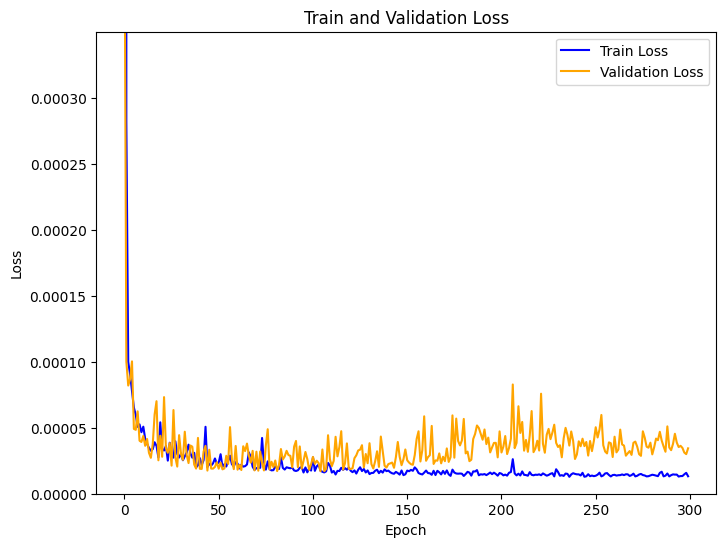

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# 학습 후 손실 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# y축 범위 설정
plt.ylim(0, 0.00035)

# y축 눈금 설정 (0.0003까지 표시)
plt.yticks(np.arange(0, 0.00031, 0.00005))

# 격자 없애기
plt.grid(False)

plt.legend()
plt.show()

In [18]:
from torchinfo import summary

summary(best_model, (1, 10, 3), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [1, 3]                    --
├─GRU: 1-1                               [1, 10, 117]              42,822
├─Linear: 1-2                            [1, 3]                    354
Total params: 43,176
Trainable params: 43,176
Non-trainable params: 0
Total mult-adds (M): 0.43
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.17
Estimated Total Size (MB): 0.18

## 테스트

### 1. 테스트 결과 생성

#### .pth 에서 불러와서 사용할 때

In [19]:
# # 모델 초기화 (저장할 때 사용한 것과 동일한 구조로)
# model = GRUModel(input_size=3, hidden_units=best_params['n_units_l0'], output_size=3, num_layers=best_params['n_layers'])

# # GPU 사용 가능 시 모델을 GPU로 이동
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# # 저장된 모델 가중치 불러오기
# model.load_state_dict(torch.load("/content/drive/MyDrive/deep-uav/1014_lookback10_forward0/best_model_1014_epoch_300.pth", map_location=device)["model_state_dict"])

# # 평가 모드로 전환 (dropout 등을 비활성화)
# model.eval()

In [20]:
# train_loader, val_loader, test_loader = prepare_dataloader(df, 17, 10)
# criterion = torch.nn.MSELoss()

#### pth 말고 학습하고 바로 사용할 때

In [21]:
model = best_model

In [22]:

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import time

# 모델 예측 및 성능 평가
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loss = 0
y_true_list = []
y_pred_list = []
total_correct = 0
total_samples = 0

threshold = 0.01  # Accuracy를 계산할 때 사용할 임계값 (오차 허용 범위)

start_time = time.time()  # 예측 시작 시간 기록

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 예측 수행
        output = model(batch_x)

        # 손실 계산
        loss = criterion(output, batch_y)
        test_loss += loss.item()

        # 예측값과 실제값 저장
        y_pred_list.append(output.cpu().numpy())  # 예측값을 CPU로 이동하여 numpy 배열로 변환
        y_true_list.append(batch_y.cpu().numpy())  # 실제값을 CPU로 이동하여 numpy 배열로 변환

        # Accuracy 계산 (오차가 threshold 이하인 경우 correct로 간주)
        y_pred_cpu = output.cpu().numpy()
        y_true_cpu = batch_y.cpu().numpy()
        correct = np.sum(np.linalg.norm(y_pred_cpu - y_true_cpu, axis=1) < threshold)
        total_correct += correct
        total_samples += len(batch_y)

end_time = time.time()  # 예측 종료 시간 기록

# 리스트를 numpy 배열로 변환
y_pred = np.concatenate(y_pred_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
accuracy = total_correct / total_samples

# 예측 시간 계산
prediction_time = end_time - start_time

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Total Prediction Time: {prediction_time:.4f} seconds')

Mean Squared Error (MSE): 1.6504840459674597e-05
Mean Absolute Error (MAE): 0.0024152682162821293
Accuracy: 91.36%
Total Prediction Time: 0.0888 seconds


### 2. 결과 시각화

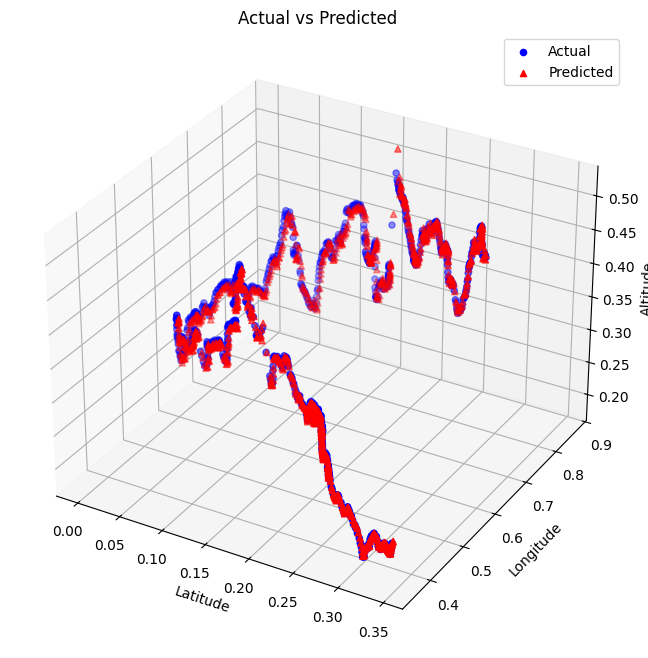

In [23]:
prediction_visualization(y_true, y_pred)

#### 3. raw 데이터와 predict 데이터 비교

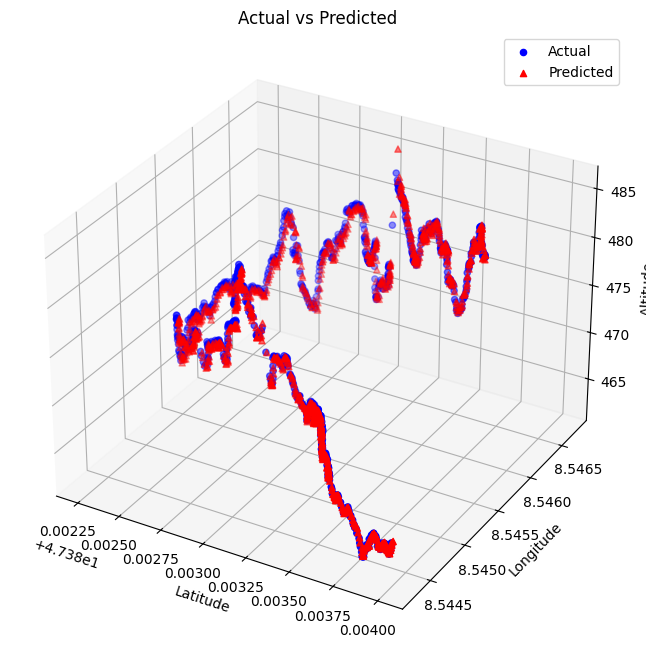

In [24]:
y_pred_original = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_true.reshape(-1, 3))

prediction_visualization(y_test_original, y_pred_original)